In [1]:
%load_ext autoreload
%autoreload 2


import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from custom_model import LSTM_fixed_len
from train import *
from utils import ReviewsDataset
from sklearn.utils import class_weight
from pyvi import ViTokenizer
from sklearn.metrics import confusion_matrix,classification_report
from collections import Counter

In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Load data

In [3]:
%pwd

'/Users/taindp/Personal/text_classifcation'

In [4]:
data_path = './data'
model_path = './model'

In [5]:
df_ = pd.read_csv(os.path.join(data_path,'question_livestream_label.csv'))

In [6]:
question = df_[df_['label']!=0]
question['label'] = [item-1 for item in list(question['label'])]
question

/Users/taindp/opt/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,label,content
0,0,thầy cho em hỏi nếu mình đã trúng tuyển chương...
2,0,cho em hỏi chương trình chất lượng cao ở bách ...
3,0,cho em hỏi nếu em đã trúng tuyển chương trình ...
5,1,cho em hỏi chỉ tiêu ngành khoa học máy tính nă...
8,1,cho em hỏi ngành khoa học máy tính có những hì...
...,...,...
428,2,cho em hỏi về ngành kỹ thuật hoá học và cơ hội...
429,2,cho em xin giới thiệu về ngành kỹ thuật robot ạ
430,2,ngành khoa học máy tính sau này ra làm công vi...
431,2,em muốn học tự động hoá thì tương lai sẽ có ng...


In [7]:
question['length'] = [len(item) for item in list(question['content'])]
question['num_word'] = [len(item.split(' ')) for item in list(question['content'])]

/Users/taindp/opt/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/taindp/opt/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
np.mean(question['num_word'])

17.30057803468208

(array([35., 81., 71., 60., 36., 28., 24.,  5.,  3.,  3.]),
 array([ 6. ,  9.6, 13.2, 16.8, 20.4, 24. , 27.6, 31.2, 34.8, 38.4, 42. ]),
 <BarContainer object of 10 artists>)

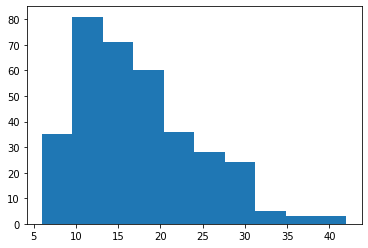

In [9]:
plt.hist(list(question['num_word']), bins = 10)

In [10]:
def tokenize(text):
    list_token = ViTokenizer.tokenize(text)
    return list_token.split(' ')

In [11]:
counts = Counter()
for index, row in question.iterrows():
    counts.update(tokenize(row['content']))

In [12]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 535
num_words after: 315


In [13]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [14]:
def encode_sentence(text, vocab2index, N=75):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
#     print(len(enc1))
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
#     print(len(encoded))
    return [encoded]
#     return encoded, length

In [15]:
N = 22
question['encoded'] = question['content'].apply(lambda x: np.array(encode_sentence(x,vocab2index,N)))
question.head()

/Users/taindp/opt/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,label,content,length,num_word,encoded
0,0,thầy cho em hỏi nếu mình đã trúng tuyển chương...,159,33,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1, 1..."
2,0,cho em hỏi chương trình chất lượng cao ở bách ...,106,24,"[[3, 4, 5, 10, 15, 16, 24, 25, 26, 21, 27, 28,..."
3,0,cho em hỏi nếu em đã trúng tuyển chương trình ...,148,31,"[[3, 4, 5, 6, 4, 8, 9, 10, 11, 12, 4, 13, 31, ..."
5,1,cho em hỏi chỉ tiêu ngành khoa học máy tính nă...,108,25,"[[3, 4, 5, 32, 33, 34, 35, 36, 37, 38, 39, 40,..."
8,1,cho em hỏi ngành khoa học máy tính có những hì...,70,16,"[[3, 4, 5, 33, 34, 35, 26, 43, 44, 45, 46, 23,..."


In [16]:
X = list(question['encoded'])
y = list(question['label'])

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=(1-0.693))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25,random_state=42)

In [17]:
len(X_train)

259

In [18]:
# class_weights = class_weight.compute_class_weight('balanced',np.unique(y).tolist(),y)
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train).tolist(),y_train)
class_weights = torch.tensor(class_weights,dtype=torch.float)
class_weights

/Users/taindp/opt/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0, 1, 2], y=[1, 0, 2, 1, 1, 0, 2, 1, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 0, 2, 2, 2, 2, 2, 0, 1, 2, 2, 0, 0, 1, 1, 1, 1, 2, 2, 1, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 1, 0, 1, 0, 2, 2, 2, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 0, 2, 1, 0, 1, 1, 2, 0, 2, 1, 1, 0, 2, 2, 1, 0, 2, 2, 2, 2, 2, 1, 0, 1, 1, 0, 2, 2, 0, 1, 0, 0, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 1, 0, 1, 2, 0, 2, 1, 1, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 1, 2, 1, 1, 0, 1, 2, 2, 1, 1, 0, 0, 2, 1, 2, 2, 2, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 2, 1, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 2, 2, 1, 1, 1, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 1, 0, 0, 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arg

tensor([1.4633, 0.9700, 0.7778])

In [19]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [20]:
batch_size = 32
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [21]:
model_fixed =  LSTM_fixed_len(
                           vocab_size = vocab_size,\
                           embedding_dim = 400,\
                           hidden_dim = 100,\
                           num_layers = 2, \
                           bidirectional=True,\
                           dropout=0.5,\
                           n_class = class_weights.shape[0])
model_fixed.cpu()

LSTM_fixed_len(
  (embeddings): Embedding(317, 400, padding_idx=0)
  (lstm): LSTM(400, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [22]:
optimizer = torch.optim.Adam(model_fixed.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight = class_weights)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [23]:

loss=[]
acc=[]
val_loss=[]
acc_max = 0

valid_loss_min = 1.

for epoch in range(30):
    train_loss = train_model(model_fixed,train_dl,optimizer,criterion,writer,epoch)
    valid_loss = evaluate(model_fixed, val_dl,criterion,writer,epoch)
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

    print(f'\tTrain Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}')
    
    if valid_loss < valid_loss_min:
        valid_loss_min = valid_loss
        checkpoint = {'model': model_fixed,
          'state_dict': model_fixed.state_dict(),
          'optimizer' : optimizer.state_dict()}
#         valis_loss_save = str(valis_loss_min).replace('.','_')[:3]
        print('Save',valid_loss,valis_loss_min)
        torch.save(checkpoint, os.path.join(model_path,'checkpoint_{}.pth'.format(valis_loss_min)))

    exp_lr_scheduler.step()


writer.flush()
writer.close()

Epoch-0 lr: 0.001
	Train Loss: 1.098 | Valid Loss: 1.084
Epoch-1 lr: 0.001
	Train Loss: 1.052 | Valid Loss: 1.047
Epoch-2 lr: 0.001
	Train Loss: 0.969 | Valid Loss: 0.881
Save 0.8809453447659811 0.8809453447659811
Epoch-3 lr: 0.001
	Train Loss: 0.802 | Valid Loss: 0.564
Save 0.5644128918647766 0.5644128918647766
Epoch-4 lr: 0.001
	Train Loss: 0.765 | Valid Loss: 0.433
Save 0.4328234593073527 0.4328234593073527
Epoch-5 lr: 0.0008
	Train Loss: 0.501 | Valid Loss: 0.384
Save 0.38387632369995117 0.38387632369995117
Epoch-6 lr: 0.0008
	Train Loss: 0.488 | Valid Loss: 0.315
Save 0.3150080939133962 0.3150080939133962
Epoch-7 lr: 0.0008
	Train Loss: 0.381 | Valid Loss: 0.334
Save 0.33389630913734436 0.33389630913734436
Epoch-8 lr: 0.0008
	Train Loss: 0.351 | Valid Loss: 0.319
Save 0.3193774123986562 0.3193774123986562
Epoch-9 lr: 0.0008
	Train Loss: 0.411 | Valid Loss: 0.355
Save 0.3550851841767629 0.3550851841767629
Epoch-10 lr: 0.00064
	Train Loss: 0.301 | Valid Loss: 0.340
Save 0.3404507984

In [24]:
# stop = 

In [25]:
# checkpoint = {'model': model_fixed,
#       'state_dict': model_fixed.state_dict(),
#       'optimizer' : optimizer.state_dict()}

# torch.save(checkpoint, os.path.join(model_path,'model_jun24.pth'))

In [26]:
# stop = 

In [41]:
load_model = load_checkpoint(os.path.join(model_path,'checkpoint_0.3150080939133962.pth'))

In [42]:
list_pred = []
list_true = []
for x,y in val_dl:
    x = x.long()
    pred = load_model(x)
    for item in pred:
#         print(item.argmax())
        list_pred.append(item.argmax().item())
    for true in y:
        list_true.append(true.item())
#         print(true.item())

In [43]:
print(classification_report(list_pred,list_true))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84        21
           1       0.94      0.91      0.93        34
           2       0.78      0.91      0.84        32

    accuracy                           0.87        87
   macro avg       0.89      0.86      0.87        87
weighted avg       0.88      0.87      0.87        87



In [44]:
np.average(f1_score(list_true, list_pred, average=None))

0.8693527025437268

# Test

In [31]:
load_model

LSTM_fixed_len(
  (embeddings): Embedding(317, 400, padding_idx=0)
  (lstm): LSTM(400, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [32]:
# filename = os.path.join(model_path,'model_intent.pth')
# joblib.dump(load_model, filename)
# # with open('vectorizer.pickle', 'wb') as handle:
# #     pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
# import requests
# url = 'https://api-intent.herokuapp.com/predict'
# pred = requests.post(url,json={'message':'ad cho em hỏi chương trình tiên tiến với chất lượng cao khác nhau thế nào ạ'})
# print(pred.json())


In [34]:
# for x,y in val_dl:
#     print(x.shape)

In [35]:
# vocab2index

In [36]:
torch.save(vocab2index,os.path.join(model_path,'vocab_apr7.pth'))

In [37]:
vocab2index = torch.load(os.path.join(model_path,'vocab_apr7.pth'))

In [38]:
N

22

In [39]:
test_sent = 'ad cho em hỏi ngành điện tử viễn thông có ổn không ạ'
test_enc =  torch.from_numpy(encode_sentence(test_sent, vocab2index, N)[0].astype(np.float32))
test_enc = torch.reshape(test_enc,(1,N))
test_enc

tensor([[272.,   3.,   4.,   5.,  33.,  65., 150.,  26.,   1.,  22.,  23.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [40]:

preds = load_model(test_enc.long())
prop_preds = nn.functional.softmax(preds,dim=1)
print(prop_preds)
pred_label = prop_preds.argmax().item()
pred_label

tensor([[0.0418, 0.0673, 0.8908]])


2